In [183]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    validation_curve,
    GridSearchCV,
)
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (
    make_scorer,
    mean_squared_error,
    r2_score,
    mean_absolute_error,
)

from sklearn.feature_selection import SelectKBest, VarianceThreshold
import time
import seaborn as sns

In [159]:
data = pd.read_csv("clean_data.csv")
data.drop(columns="Unnamed: 0", inplace=True)
data

,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,SiteEnergyUse(kBtu),TotalGHGEmissions,ElectricityUse(Percentage),SteamUse(Percentage),NaturalGasUse(Percentage),...,ThirdLargestUseTypeGFA(Percentage),ParkingGFA(Percentage),NumberOfYearsENERGYSTARCertified,BuildingAge,NumberOfPropertyUses,Leisure,MedicalFacility,School,ServiceFacility,Store
0,47.61220,-122.33799,0.30103,1.113943,4.946624,6.858920,2.399639,54.61,27.73,17.66,...,0.00,0.00,0.0,89,1,1.0,0.0,0.0,0.0,0.0
1,47.61317,-122.33393,0.30103,1.079181,5.015221,6.923655,2.472552,38.66,0.00,61.34,...,4.46,14.55,0.0,20,3,1.0,0.0,0.0,1.0,0.0
2,47.61393,-122.33810,0.30103,1.623249,5.980508,7.860859,3.320204,68.23,29.71,2.06,...,0.00,20.57,0.0,47,1,1.0,0.0,0.0,0.0,0.0
3,47.61412,-122.33664,0.30103,1.041393,4.787609,6.832163,2.458532,40.75,32.59,26.66,...,0.00,0.00,0.0,90,1,1.0,0.0,0.0,0.0,0.0
4,47.61375,-122.34047,0.30103,1.278754,5.244478,7.151450,2.704159,37.88,0.00,62.12,...,0.00,35.31,0.0,36,3,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1532,47.54067,-122.37441,0.30103,0.301030,4.261548,5.969455,1.328991,67.84,0.00,32.16,...,0.00,0.00,0.0,34,1,1.0,0.0,0.0,1.0,0.0
1533,47.59625,-122.32283,0.30103,0.301030,4.204147,5.977850,1.520745,41.73,0.00,58.27,...,0.00,0.00,0.0,12,1,1.0,0.0,0.0,1.0,0.0
1534,47.63644,-122.35784,0.30103,0.301030,4.119190,6.760867,2.351294,31.08,0.00,68.92,...,0.00,0.00,0.0,42,3,1.0,0.0,0.0,1.0,0.0
1535,47.52832,-122.32431,0.30103,0.301030,4.149281,5.857014,1.363800,48.49,0.00,51.51,...,3.43,0.00,0.0,27,5,1.0,0.0,1.0,1.0,0.0


# Testing different predictive models 

# Preparing the data

### Feature selection with SelectKBest

In [139]:
y = data["SiteEnergyUse(kBtu)"]
X = data.drop(columns=["SiteEnergyUse(kBtu)", "TotalGHGEmissions"], axis=1)
selector = SelectKBest(k=15)
selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support()]

/Users/amelie-dzovinar/Dev/anaconda3/envs/p4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)


In [104]:
selected_features

Index(['ElectricityUse(Percentage)', 'SteamUse(Percentage)',
       'NaturalGasUse(Percentage)', 'LargestUseTypeGFA(Percentage)',
       'SecondLargestUseTypeGFA(Percentage)',
       'ThirdLargestUseTypeGFA(Percentage)', 'ParkingGFA(Percentage)',
       'NumberOfYearsENERGYSTARCertified', 'BuildingAge',
       'NumberOfPropertyUses', 'Leisure', 'MedicalFacility', 'School',
       'ServiceFacility', 'Store'],
      dtype='object')

In [84]:
# y = data["SiteEnergyUse(kBtu)"]
# X = data.drop(columns=["SiteEnergyUse(kBtu)", "TotalGHGEmissions"], axis=1)
# selector = VarianceThreshold(threshold=0.2)
# selector.fit_transform(X)

# selected_features = X.columns[selector.get_support()]

In [140]:
y_energy_use = y
X = data[selected_features]

In [160]:
y_energy_use = data["SiteEnergyUse(kBtu)"]
X = data.drop(columns=["SiteEnergyUse(kBtu)", "TotalGHGEmissions"], axis=1)

## Separation of training and test data

In [161]:
(
    X_train_energy_use,
    X_test_energy_use,
    y_train_energy_use,
    y_test_energy_use,
) = train_test_split(X, y_energy_use, test_size=0.2, random_state=42)

## Normalization 

In [180]:
scaler = RobustScaler()
X_train_energy_use = scaler.fit_transform(X_train_energy_use)
X_test_energy_use = scaler.transform(X_test_energy_use)

## Comparing metrics 

While MAE is less impacted by outliers, we will favor RMSE since this metric is more strict with large errors.

# Comparing different models 

## Linear Regression

In [181]:
model = LinearRegression()
model = model.fit(X_train_energy_use, y_train_energy_use)

train_score = model.score(X_train_energy_use, y_train_energy_use)
test_score = model.score(X_test_energy_use, y_test_energy_use)
print("Train score: ", train_score)
print("Test score: ", test_score)

Train score:  0.6633015285108166
Test score:  0.6375490694718409


Performing cross validation on a linear regression model

In [182]:
cross_val_score(
    LinearRegression(), X_train_energy_use, y_train_energy_use, cv=10
).mean()

0.6436411189520996

## SVR

In [91]:
y_train_energy_use = np.array(y_train_energy_use).ravel()
c = np.arange(0, 100)

train_score, validation_score = validation_curve(
    SVR(),
    X_train_energy_use,
    y_train_energy_use,
    param_name="C",
    param_range=c,
    cv=10,
    scoring="r2",
)

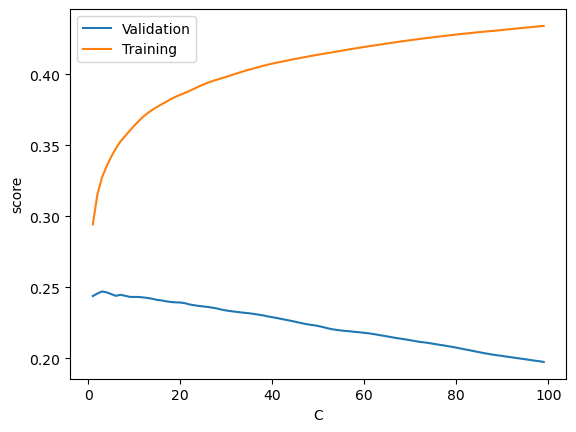

In [92]:
plt.plot(c, validation_score.mean(axis=1), label="Validation")
plt.plot(c, train_score.mean(axis=1), label="Training")

plt.ylabel("score")
plt.xlabel("C")
plt.legend()
plt.show()

# Models

## Identifying optimal parameters with GridSearchCV

In [164]:
def grid_search(model, params):
    scoring = {
        "r2": make_scorer(r2_score),
        "neg_mean_squared_error": make_scorer(mean_squared_error),
        "neg_mean_absolute_error": make_scorer(mean_absolute_error),
    }
    start = time.time()

    grid = GridSearchCV(
        model, params, cv=5, scoring=scoring, refit="neg_mean_squared_error"
    )
    grid.fit(X_train_energy_use, y_train_energy_use)

    elapsed_time = time.time() - start
    results = {
        "Model": str(model),
        "Mean Fit Time": grid.cv_results_["mean_fit_time"].mean(),
        "Mean R2": grid.cv_results_["mean_test_r2"].mean(),
        "Mean MAE": (grid.cv_results_["mean_test_neg_mean_absolute_error"].mean()),
        "Mean RMSE": (
            np.sqrt((grid.cv_results_["mean_test_neg_mean_squared_error"].mean()))
        ),
        "Best params": str(grid.best_params_),
        "Runtime": elapsed_time,
    }

    return pd.DataFrame(results, index=[0])

In [116]:
model_comparison = pd.DataFrame()

### SVR

In [168]:
param_grid = {
    "C": [1, 5, 20, 50, 100, 150],
    "epsilon": [0, 0.01, 0.1, 0.5, 1, 2],
}

svr_results = grid_search(SVR(), param_grid)

In [169]:
model_comparison = pd.concat([model_comparison, svr_results], ignore_index=True)

### ElasticNet

In [165]:
param_grid = {
    "alpha": [100, 120, 150, 200],
    "l1_ratio": [0.5, 1],
    "max_iter": [500, 1000, 1500, 2000],
    "selection": ["cyclic", "random"],
}

elastic_net_results = grid_search(ElasticNet(), param_grid)

In [166]:
model_comparison = pd.concat([model_comparison, elastic_net_results], ignore_index=True)

### RandomForest

In [173]:
param_grid = {
    "n_estimators": [100, 120, 150, 200],
    "max_depth": [1, 10, 15, 20, 25, None],
    "min_samples_split": [2, 4, 6, 8, 10],
    "max_features": ["sqrt", "log2", None],
}

random_forest_results = grid_search(RandomForestRegressor(), param_grid)

In [174]:
model_comparison = pd.concat(
    [model_comparison, random_forest_results], ignore_index=True
)

In [175]:
model.feature_importances_

AttributeError: 'LinearRegression' object has no attribute 'feature_importances_'

### Gradient Boosting

In [120]:
param_grid = {
    "n_estimators": [100, 120, 150, 200],
    "loss": ["squared_error", "absolute_error", "huber", "quantile"],
    "min_samples_split": [2, 4, 6, 8, 10],
    "max_features": ["sqrt", "log2", None],
}

gradient_boosting_results = grid_search(GradientBoostingRegressor(), param_grid)

In [121]:
model_comparison = pd.concat(
    [model_comparison, gradient_boosting_results], ignore_index=True
)

In [176]:
model_comparison

,Model,Mean Fit Time,Mean R2,Mean MAE,Mean RMSE,Best params,Runtime
0,SVR(),0.028241,0.556352,0.644468,0.847723,"{'C': 1, 'epsilon': 2}",6.134170
1,GradientBoostingRegressor(),0.180842,0.505467,0.680511,0.894792,"{'loss': 'quantile', 'max_features': None, 'mi...",218.938142
2,ElasticNet(),0.001787,-0.003302,1.028470,1.276935,"{'alpha': 100, 'l1_ratio': 0.5, 'max_iter': 50...",0.871634
3,ElasticNet(),0.002577,-0.003302,1.028470,1.276935,"{'alpha': 100, 'l1_ratio': 0.5, 'max_iter': 50...",1.398836
4,ElasticNet(),0.002113,-0.003302,1.028470,1.276935,"{'alpha': 100, 'l1_ratio': 0.5, 'max_iter': 50...",1.019127
5,ElasticNet(),0.001972,-0.003302,1.028470,1.276935,"{'alpha': 100, 'l1_ratio': 0.5, 'max_iter': 50...",0.954092
6,ElasticNet(),0.001419,-0.003302,1.028470,1.276935,"{'alpha': 100, 'l1_ratio': 0.5, 'max_iter': 50...",0.781364
7,ElasticNet(),0.001884,-0.003302,1.028470,1.276935,"{'alpha': 100, 'l1_ratio': 0.5, 'max_iter': 50...",0.956233
8,ElasticNet(),0.001618,-0.003302,0.446659,0.554566,"{'alpha': 100, 'l1_ratio': 0.5, 'max_iter': 50...",0.857946
9,SVR(),0.031719,0.453345,0.310557,0.408814,"{'C': 1, 'epsilon': 2}",6.564898
